In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from astropy.coordinates import SkyCoord
from astropy import units as u

In [28]:
plt.rc('font', family="serif")
plt.rc('font', size=12)
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
path_data = "/project2/chihway/raulteixeira/data/"

# Get catalogs

0 U
1 G
2 R


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


3 I
4 Z
5 J
6 H
7 KS


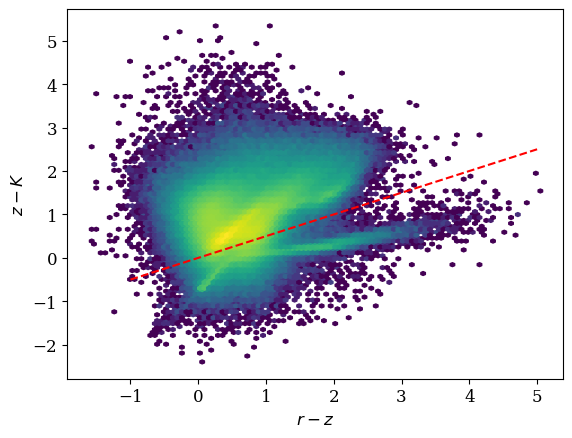

In [29]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


deep = pd.read_table(path_data+"deepfields.csv.gz", sep=',', header=0)


# Mask flagged regions
mask = deep.MASK_FLAGS_NIR==0
mask &= deep.MASK_FLAGS==0
mask &= deep.FLAGS_NIR==0
mask &= deep.FLAGS==0
mask &= deep.FLAGSTR=="b'ok'"
mask &= deep.FLAGSTR_NIR=="b'ok'"
deep = deep[mask]
deep = deep.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
bands = ["U","G","R","I","Z","J","H","KS"]
mags_d = np.zeros((len(deep),len(bands)))
magerrs_d = np.zeros((len(deep),len(bands)))

for i,band in enumerate(bands):
    print(i,band)
    mags_d[:,i] = flux2mag(deep['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(deep),len(bands)-1))
for i in range(len(bands)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

deep = deep[normal_colors]

# mask faint objects, i < 25
deep = deep[flux2mag(deep.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(deep.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(deep.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(deep.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(deep.BDF_FLUX_DERED_CALIB_KS.values)


plt.hexbin((r-z), (z-k), gridsize=100, mincnt=1, bins='log')
_t = np.linspace(-1, 5, 100)
plt.plot(_t, 0.5*_t, color='r', ls='--')
plt.xlabel(r"$r-z$")
plt.ylabel(r"$z-K$")
plt.show()

# mask stars based on (z−K) > 0.5×(r −z) color cut

deep = deep[(z-k) > 0.5*(r-z)]

deep["FIELD"] = np.nan
msk = deep.RA.values > 125
deep.loc[msk, 'FIELD'] = "COSMOS"
msk = (deep.RA.values > 45) & (deep.RA.values < 125) 
deep.loc[msk, 'FIELD'] = "C3"
msk = (deep.RA.values > 25) & (deep.RA.values < 45) 
deep.loc[msk, 'FIELD'] = "X3"
msk = (deep.RA.values < 25) 
deep.loc[msk, 'FIELD'] = "E2"

In [30]:
pauscosmos = pd.read_parquet(path_data+"pauscosmos.parquet")
cosmos2020 = pd.read_parquet(path_data+"cosmos2020_classic.parquet")

#delve = pd.read_hdf(path_data+'DELVE_table1_000001.h5', key='data/table', mode='r')

specz = pd.read_table("/project2/chihway/delve_shear/BRPORTAL_E_6315_18670.csv", sep=',')

In [7]:
def get_C3R2():
    c3r2_lines = open(path_data+'c3r2_DR1+DR2_2019april11.txt').readlines()
    c3r2 = []
    for line in c3r2_lines[40:]:
        line = np.array(line.split(' '))
        line = line[line!='']
        line = line[:-1]
        ra = (360/24.)*(float(line[1]) + float(line[2])/60. + float(line[3])/3600.)
        dec = float(line[4]) + float(line[5])/60. + float(line[6])/3600.
        imag, zspec, qf = float(line[9]), float(line[10]), float(line[11])
        instr = line[12]
        c3r2.append([ra,dec,imag, zspec, qf,instr])

    c3r2_lines = open(path_data+'C3R2-DR3-18june2021.txt').readlines()
    for line in c3r2_lines[36:]:
        line = np.array(line.split(' '))
        line = line[line!='']
        line = line[:-1]
        ra = (360/24.)*(float(line[1]) + float(line[2])/60. + float(line[3])/3600.)
        dec = float(line[4]) + float(line[5])/60. + float(line[6])/3600.
        imag, zspec, qf = float(line[9]), float(line[10]), float(line[11])
        instr = line[12]
        c3r2.append([ra,dec,imag, zspec, qf,instr])

    c3r2 = pd.DataFrame(c3r2, columns=['ra','dec','imag','zspec','qf','Instr'])
    c3r2 = c3r2.loc[:, ['ra','dec','zspec']]
    c3r2['SOURCE'] = 'C3R2_PUBLIC'
    return c3r2

c3r2 = get_C3R2()

# Match redshift catalogs to deep galaxies

In [32]:
deep["Z"] = np.nan
deep["SOURCE"] = np.nan

In [33]:
def match_zcat_to_deepcat(zcat, z_col, ra_col, dec_col, source_name, deepcat):
    
    # Match spectra to DELVE catalog
    spec_cd = SkyCoord(ra=zcat[ra_col].values*u.degree, dec=zcat[dec_col].values*u.degree)
    deep_cd = SkyCoord(ra=deepcat['RA'].values*u.deg, dec=deepcat['DEC'].values*u.deg)
    idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
    good_matches = d2d < 1.0*u.arcsec
    # print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

    # Add spectra to DELVE catalog
    output = deepcat.copy()
    output.loc[good_matches, 'Z'] = zcat.iloc[idx[good_matches], zcat.columns.get_loc(z_col)].values
    output.loc[good_matches, 'SOURCE'] = source_name
    return output



We will match each source of redshift information sequentially. First we will match the least reliable catalog, and we will continue by matching more and more reliable sources of information, possibly overwritting previous redshift information.

In [34]:
deep = match_zcat_to_deepcat(cosmos2020, "ez_z_phot", "alpha_j2000", "delta_j2000", "COSMOS2020", deep)
deep = match_zcat_to_deepcat(pauscosmos, "photoz", "ra", "dec", "PAUS+COSMOS", deep)
deep = match_zcat_to_deepcat(specz, "Z", "RA", "DEC", "SPECZ", deep)
deep = match_zcat_to_deepcat(c3r2, "zspec", "ra", "dec", "C3R2", deep)


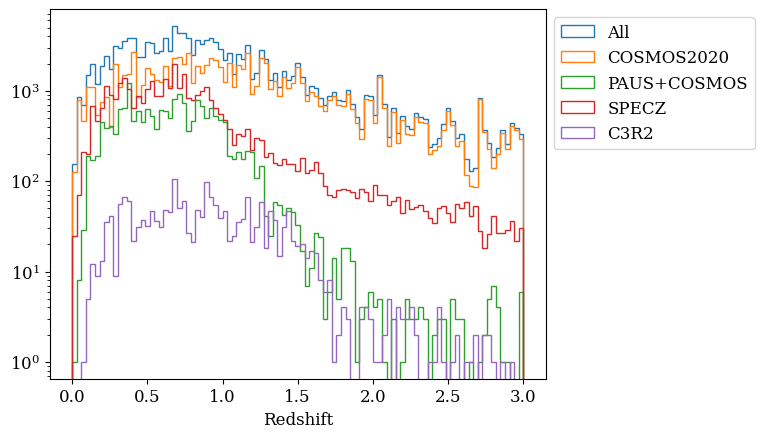

In [35]:
_bins = np.linspace(0,3,100)
plt.hist(deep.Z.values, _bins, histtype='step', label='All')
plt.hist(deep.Z.values[deep.SOURCE=="COSMOS2020"], _bins, histtype='step', label='COSMOS2020')
plt.hist(deep.Z.values[deep.SOURCE=="PAUS+COSMOS"], _bins, histtype='step', label='PAUS+COSMOS')
plt.hist(deep.Z.values[deep.SOURCE=="SPECZ"], _bins, histtype='step', label='SPECZ')
plt.hist(deep.Z.values[deep.SOURCE=="C3R2"], _bins, histtype='step', label='C3R2')
plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')
plt.xlabel("Redshift")
plt.savefig('deepfields_redshiftinfo_hist.pdf',bbox_inches='tight')
plt.savefig('deepfields_redshiftinfo_hist.png',bbox_inches='tight', dpi=300)
plt.show()

162205
146458
141009
160656


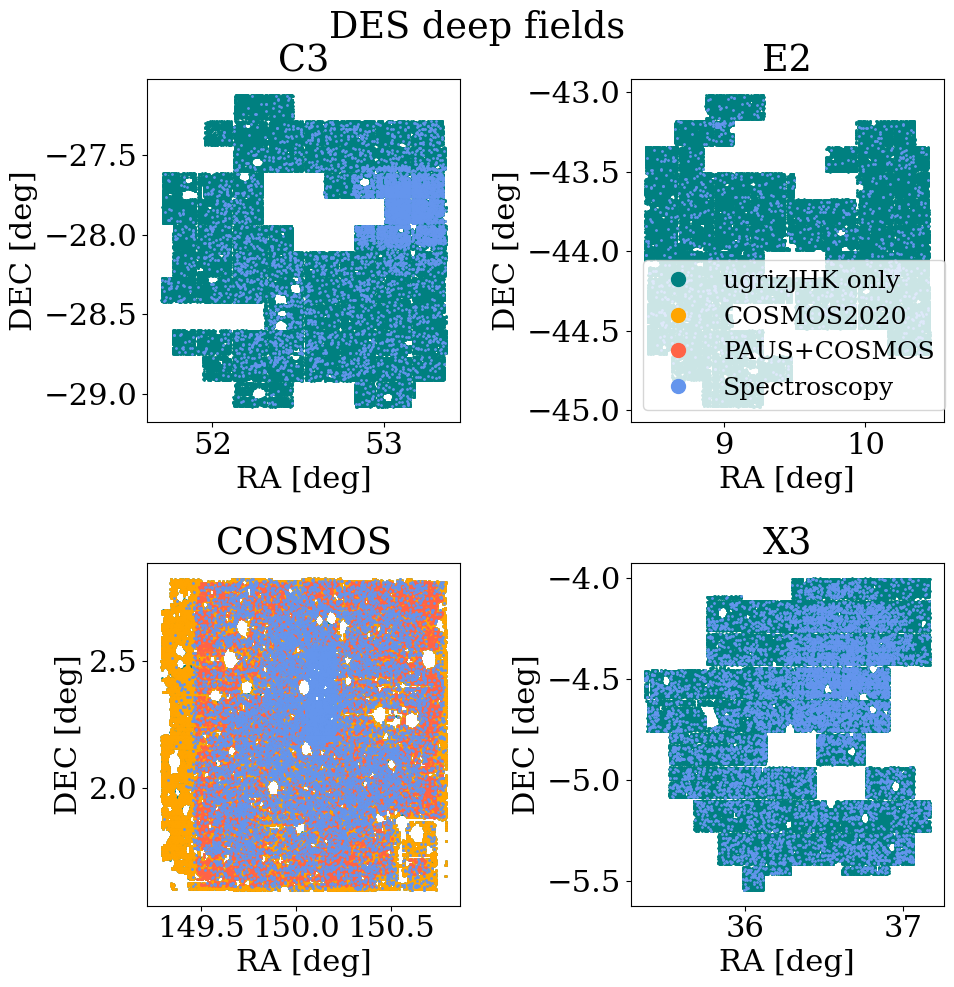

In [12]:
colors = ['teal', 'orange', 'cornflowerblue','tomato']
fields = ['C3', 'COSMOS', 'E2', 'X3']

fig, ax = plt.subplots(2,2, figsize=(10,10))
#"""
msize=10
legend_elements = [Line2D([0], [0], marker='o', color='none',markerfacecolor=colors[0], markeredgecolor=colors[0], markersize=msize,
                         label='ugrizJHK only'),
                   Line2D([0], [0], marker='o', color='none',markerfacecolor=colors[1], markeredgecolor=colors[1], markersize=msize,
                         label='COSMOS2020'),
                   Line2D([0], [0], marker='o', color='none',markerfacecolor=colors[3], markeredgecolor=colors[3], markersize=msize,
                         label='PAUS+COSMOS'),
                   Line2D([0], [0], marker='o', color='none',markerfacecolor=colors[2], markeredgecolor=colors[2], markersize=msize,
                         label='Spectroscopy'),
                  ]
#"""
for i in range(2):
    for j in range(2):
        ij = i+2*j
        field = fields[ij]
        sub_bal = deep[deep.FIELD == field]
        print(len(sub_bal))
        ax[i,j].scatter(sub_bal.RA.values, sub_bal.DEC.values, s=1, color = colors[0],
                       label='No redshift')

        sub_bal = deep[(deep.FIELD == field)&(deep.SOURCE == "COSMOS2020")]
        ax[i,j].scatter(sub_bal.RA.values, sub_bal.DEC.values, s=1, color = colors[1],
                       label='COSMOS2020')
        sub_bal = deep[(deep.FIELD == field)&(deep.SOURCE == "PAUS+COSMOS")]
        ax[i,j].scatter(sub_bal.RA.values, sub_bal.DEC.values, s=1, color = colors[3],)
        sub_bal = deep[(deep.FIELD == field)&((deep.SOURCE == "SPECZ")|(deep.SOURCE == "C3R2"))]
        ax[i,j].scatter(sub_bal.RA.values, sub_bal.DEC.values, s=1, color = colors[2],)
        
        ax[i,j].set_title(field)
        ax[i,j].set_xlabel('RA [deg]')
        ax[i,j].set_ylabel('DEC [deg]')
ax[0,1].legend(loc=0, handles=legend_elements, fontsize=18, frameon=True)
fig.tight_layout()
fig.suptitle("DES deep fields", y=1.0)
#plt.savefig('deepfields_redshiftinfo_area.pdf',bbox_inches='tight')
plt.savefig('deepfields_redshiftinfo_area.png',bbox_inches='tight', dpi=300)
plt.show()

(array([8.700e+01, 5.470e+02, 1.007e+03, 9.780e+02, 1.692e+03, 1.413e+03,
        2.241e+03, 3.566e+03, 1.960e+03, 1.668e+03, 2.053e+03, 1.642e+03,
        1.745e+03, 2.828e+03, 3.011e+03, 1.591e+03, 2.142e+03, 2.200e+03,
        2.149e+03, 1.561e+03, 1.199e+03, 4.630e+02, 5.690e+02, 5.940e+02,
        4.360e+02, 2.840e+02, 1.360e+02, 1.520e+02, 1.150e+02, 1.500e+02,
        5.700e+01, 2.600e+01, 7.400e+01, 2.400e+01, 2.400e+01, 2.200e+01,
        6.400e+01, 2.300e+01, 7.000e+00, 1.500e+01, 8.000e+00, 1.600e+01,
        0.000e+00, 9.000e+00, 6.000e+00, 6.000e+00, 1.100e+01, 2.000e+00,
        6.000e+00, 8.000e+00, 1.400e+01, 6.000e+00, 2.000e+00, 5.000e+00,
        1.100e+01, 1.900e+01, 1.400e+01, 2.000e+00, 2.000e+00, 1.000e+01]),
 array([0.        , 0.04983333, 0.09966667, 0.1495    , 0.19933333,
        0.24916667, 0.299     , 0.34883333, 0.39866667, 0.4485    ,
        0.49833333, 0.54816667, 0.598     , 0.64783333, 0.69766667,
        0.7475    , 0.79733333, 0.84716667, 0.897     

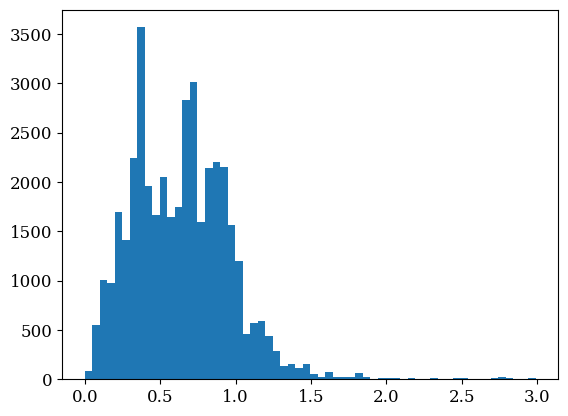

In [25]:
plt.hist(pauscosmos['photoz'],bins=60)

(array([12063., 45477., 37690., 35219., 20285., 16519., 13962., 13639.,
        12772., 52906., 19443., 16444., 19961., 58687., 30029., 20222.,
        17687., 15132., 14347., 16470., 14196., 12668., 26297., 32850.,
        30918., 32870., 15077., 35665., 19771., 27133., 25517., 24609.,
        15611., 11274., 24548., 11331., 15622., 20600., 17641., 10945.,
        12287., 17135., 17601., 21500.,  9016.,  8570., 10171.,  8570.,
        11434., 16612., 17002.,  4918.,  7155.,  9112.,  8823.,  4969.,
         7473.,  7560.,  7550.,  6197.,  5742.,  5146.,  6061.,  4658.,
         8033.,  6259.,  4744., 12163.,  5685.,  5611.,  9147.,  3890.,
         5882.,  4133.,  5328.,  8869.,  6001.,  5382.,  3005.,  3671.,
         4825.,  5857.,  4073.,  6713.,  7186., 10967.,  4276.,  4045.,
         6356., 12881.,  6170.,  3877.,  3958.,  5078.,  6198.,  5653.,
         7700.,  8234.,  6799.]),
 array([0.        , 0.03030303, 0.06060606, 0.09090909, 0.12121212,
        0.15151515, 0.18181818, 0.

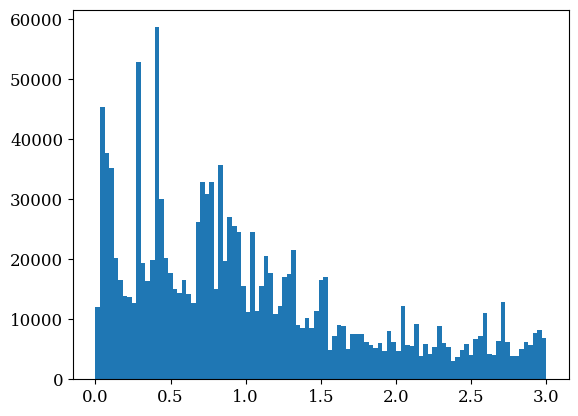

In [27]:
plt.hist(cosmos2020['ez_z_phot'], bins=np.linspace(0, 3, 100))